In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import glob
from urllib.request import urlopen, Request 
from path import Path, getcwdu
import os
from pathlib import PurePath

import re

In [2]:
train_file_list = [PurePath(file).name for file in glob.iglob('data/nc_training_filings/*')]
train_path_list = [PurePath(os.getcwd()).joinpath(file).as_posix() for file in glob.iglob('data/nc_training_filings/*')]
train_accession_ids = [PurePath(file).stem for file in train_file_list]
train_cik_nbrs = [x.split(sep='-')[0] for x in train_accession_ids]

In [198]:
repurch_pat = re.compile(r'authorized the purchase|repurchase|[^0-9a-z]ASR|Shares Purchased|Share buyback|common stock purchase|purchase an additional|remaining share', flags=re.I)
#r'.*(authorized the purchase|repurchase|ASR|Shares Purchased|purchased|common stock purchase|purchase an additional|remaining share).*'

In [3]:
srp_df = pd.read_csv('data/share_repurchase_paragraphs.csv').sort_values('accession_number').reset_index()

In [4]:
srp_df['para_len'] = srp_df['paragraph_text'].apply(lambda x: len(x))

In [6]:
train_path_list[0]

'c:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0000002969-17-000039.html'

In [152]:
srp_df.columns

Index(['index', 'ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units', 'paragraph_text',
       'para_len'],
      dtype='object')

In [138]:
import matplotlib.pyplot as plt

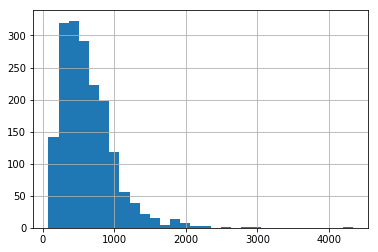

In [141]:
srp_df.para_len.hist(bins=30)
plt.show()

In [33]:
def print_para_info(df=srp_df, nrow=10, sortby=['accession_number', 'data_key_friendly_name'], ascending=True):
    df_sorted = df.sort_values(sortby, ascending=ascending).reset_index()
    nrow = min(len(df_sorted), nrow)
    for i in range(0, nrow):
        print('------------------------------------   ' +  df_sorted['ticker'][i] + '   --------------------------------')
        print('------------------------------------   ' +  df_sorted['accession_number'][i] + '   --------------------------------')
        print (df_sorted['data_key_friendly_name'][i])
        print('')
        print(df_sorted['text'][i])
        print('')
        print(df_sorted['paragraph_text'][i])
        print('')

In [337]:
print_para_info(df=srp_df[srp_df.accession_number == '0001564590-18-002832'], sortby=['para_len'], ascending=False)

------------------------------------   TXN   --------------------------------
------------------------------------   0001564590-18-002832   --------------------------------
Amount Spent on Share Repurchases

Stock repurchases

For Years Ended December 31,   (Millions of   dollars, except   share and per-share   amounts)                   2017              2016              2015              2014              2013   Cash flow data:   Cash flows from   operating activities   $      5,363      $      4,614      $      4,397      $      4,054      $      3,514   Capital expenditures            695               531               551               385               412   Free cash flow (a)            4,668             4,083             3,846             3,669             3,102   Dividends paid                2,104             1,646             1,444             1,323             1,175   Stock repurchases             2,556             2,132             2,741             2,831             2,8

Examine records with long paragraph length

In [146]:
srp_df.sort_values(['para_len'], ascending=False).head()

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
309,1273,PEP,0000077476-18-000012,Share Repurchase Count,Share repurchases,18000000,18.0,millions,2017 2016 20...,4332
311,1279,PEP,0000077476-18-000012,Amount Spent on Share Repurchases,Share repurchases,2000000000,2000.0,millions,2017 2016 20...,4332
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.0,millions,"For Years Ended December 31, (Millions of ...",3017
392,1645,UTX,0000101829-18-000005,Amount Spent on Share Repurchases,Repurchases of Common Stock ^3,1453000000,1453.0,millions,"(dollars in millions, except per share amounts...",2899
1478,1126,MMM,0001558370-18-000535,Share Repurchase Intention,"Total January 1-December 31, 2017",5070000000,5070.0,millions,Maximum ...,2536


In [155]:
srp_df[srp_df.accession_number == '0001564590-18-002832']

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1576,1599,TXN,0001564590-18-002832,Share Repurchase Intention,stock repurchase authorizations remain,9240000000,9.24,billions,Treasury shares were acquired in connection wi...,223
1577,1595,TXN,0001564590-18-002832,Share Repurchase Authorization,board of directors authorized the purchase of ...,6000000000,6.00,billions,All open-market purchases during the quarter w...,348
1578,1596,TXN,0001564590-18-002832,Share Repurchase Authorization Date,"September 21, 2017",20170921,20200000.00,ones,All open-market purchases during the quarter w...,348
1579,1597,TXN,0001564590-18-002832,Share Repurchase Count,repurchase,30600000,30.60,millions,"In 2017, financing activities used $3.73 billi...",764
1580,1594,TXN,0001564590-18-002832,Share Repurchase Authorization,authorization,7500000000,7.50,billions,All open-market purchases during the quarter w...,348
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.00,millions,"For Years Ended December 31, (Millions of ...",3017


In [43]:
print_para_info(df = srp_df[srp_df.ticker=='GOOGL'], ascending=False)

------------------------------------   GOOGL   --------------------------------
------------------------------------   0001652044-18-000007   --------------------------------
Share Repurchase Utilization

aggregate amount

During 2017, we repurchased and subsequently retired 5.2 million shares of Alphabet Class C capital stock for   an aggregate amount of $4.8 billion

------------------------------------   GOOGL   --------------------------------
------------------------------------   0001652044-18-000007   --------------------------------
Share Repurchase Intention

December 1 - 31

Total Number of Shares                                                              Purchased as Part of     Approximate Dollar Value                   Total Number of                             Publicly Announced      of Shares that May Yet Be                 Shares Purchased (in  Average Price Paid   Programs (in thousands)       Purchased Under the      Period       thousands) ^(1)       per Share ^(2

In [133]:
len(missed_df.accession_number.unique())

74

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
45,57,ADP,0000008670-17-000010,Share Repurchase Authorization Date,August 2015,20150815,20200000.0,ones,Date of Approval Shares August 2014 ...,88
47,55,ADP,0000008670-17-000010,Unknown Share Repurchase Data,August 2015,25000000,25.0,millions,Date of Approval Shares August 2014 ...,88
86,342,CAT,0000018230-18-000042,Share Repurchase Utilization,was spent,4500000000,4.5,billions,We did not purchase any Caterpillar common sto...,169
115,423,CMI,0000026172-18-000011,Share Repurchase Authorization Date,December 2016,20161215,20200000.0,ones,In millions Common Stock Tr...,862
138,586,EMR,0000032604-17-000046,Share Repurchase Authorization Date,November 2015,20151115,20200000.0,ones,Steven J. Pelch was appointed Executive Vice P...,361


In [199]:
df_pat = re.compile(r'.*(authorized the purchase|repurchase|[^0-9a-z]ASR|Shares Purchased|Share buyback|common stock purchase|purchase an additional|remaining share).*', flags=re.I)
#missed_df = srp_df[srp_df.paragraph_text.str.match(df_pat) == False]
missed_df = srp_df[(srp_df.paragraph_text.str.match(df_pat) == False) & (srp_df.text.str.match(df_pat) == False)]

hit_df = srp_df[(srp_df.paragraph_text.str.match(df_pat) == True) | (srp_df.text.str.match(df_pat) == True)]

In [200]:
len(hit_df.accession_number.unique())

431

In [155]:
print_para_info(df=missed_df[missed_df.data_key_friendly_name =='Amount Spent on Share Repurchases'], ascending=False)

------------------------------------   CLX   --------------------------------
------------------------------------   0001628280-17-008700   --------------------------------
Amount Spent on Share Repurchases

Evergreen Program

2017                       2016                       2015                     Amount  Shares (in 000's)  Amount  Shares (in 000's)  Amount  Shares (in 000's)   Evergreen Program $ 189         1,505        $ 254         2,151        $ 434         4,016

------------------------------------   SLB   --------------------------------
------------------------------------   0001564590-18-000821   --------------------------------
Amount Spent on Share Repurchases

2017

(Stated in thousands, except per share amounts)        Total Cost    Total Number   Average Price         of Shares     of Shares       Paid per         Purchased     Purchased         Share   2017 $   968,676       13,249.7   $       73.11   2016 $   778,018       10,988.5   $       70.80   2015 $ 2,182

In [90]:
missed_df[['data_key_friendly_name', 'accession_number']].groupby('data_key_friendly_name').count()

,accession_number
data_key_friendly_name,
Amount Spent on Share Repurchases,12
Share Repurchase Authorization,7
Share Repurchase Authorization Date,30
Share Repurchase Count,14
Share Repurchase Intention,5
Share Repurchase Utilization,3
Unknown Share Repurchase Data,2


In [91]:
missed_df.text.value_counts()

2017                                                                                    8
December 2017                                                                           7
Total                                                                                   5
December 2016                                                                           4
2016                                                                                    3
December 15, 2015                                                                       3
For the year ended December 31, 2017                                                    2
August 2015                                                                             2
Fiscal Year 2017                                                                        2
December 31, 2017                                                                       2
Evergreen Program                                                                       2
February 2

This table was identifed as a paragraph. The word sequence doesn't work. The div above it clearly talks about share repurchase and "following table." 

In [72]:
missed_df[(missed_df.accession_number == '0001628280-18-001872') & (
    missed_df.data_key_friendly_name == 'Share Repurchase Intention') ].paragraph_text.apply(
lambda x: re.sub(r' +', ' ', x)).values
#values.astype('str')[0].re.su



array(['(millions, except per share data) (d) (c) Approximate Total Dollar Number Value of of Shares Shares (a) Purchased that May Total (b) as Part of Yet Be Number Average Publicly Purchased of Price Announced Under the Shares Paid Per Plans or Plans or Period Purchased Share Programs Programs Month #1: 10/01/17-10/28/17 - - - $ 558 Month #2: 10/29/17-11/25/17 - - - $ 558 Month #3: 11/26/17-12/30/17 - - - $ 558'],
      dtype=object)

In [77]:
srp_df[(srp_df.accession_number == '0001628280-18-001872')]

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1721,947,K,0001628280-18-001872,Share Repurchase Authorization,a new authorization by the board of directors ...,1500000000,1.5,billions,"In December 2015, the board of directors appro...",360
1722,950,K,0001628280-18-001872,Share Repurchase Intention,11/26/17-12/30/17,558000000,558.0,millions,"(millions, except per share data) ...",1034
1723,949,K,0001628280-18-001872,Amount Spent on Share Repurchases,for a total of,516000000,516.0,millions,"During 2017, the Company repurchased 7 million...",305
1724,948,K,0001628280-18-001872,Share Repurchase Authorization Date,December 2017,20171215,20200000.0,ones,(123 ) (339 ) Non-cash charges and other ...,262
1725,946,K,0001628280-18-001872,Share Repurchase Count,repurchased,7000000,7.0,millions,"During 2017, the Company repurchased 7 million...",305


In [ ]:
print_para_info

In [ ]:
#https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000002969&type=10-K&dateb=20171031&owner=include&count=40

In [202]:

def df_from_html_tbl(table_tag):
    data_re = re.compile(r'[a-zA-Z0-9$().]+')
    repl = re.compile(r'[()$]')
    rows = []
    for row in table_tag.findChildren('tr'):
        row_list = []
        for s in row.strings:
            s = re.sub(repl, '', s.strip())
            if len(s) > 0:
                row_list.append(s)
        if len(row_list) > 1:
            rows.append(row_list)
    tbl_df = pd.DataFrame.from_records(rows)
    try:
        tbl_df = tbl_df.set_index( tbl_df.applymap(len).max().values.argmax()) 
    except: tbl_df = tbl_df.set_index(0)
    return tbl_df

In [256]:

#repurch_TXN = soup_TXN.find_all(string=[repurch_pat])
def print_repurch_hits(filepath):
    try:
        with open(filepath, encoding="utf8") as file: 
            file_html = file.read()
            soup = BeautifulSoup(file_html, 'lxml')
    except: 
        with open(filepath) as file: 
            file_html = file.read()
            soup = BeautifulSoup(file_html, 'lxml')
    soup_repurch = soup.find_all(string=[repurch_pat])
    text_dict = {} 
    df_dict = {}
    html_list = []
    for idx, item in enumerate(soup_repurch):
        if item.find_parent('table') is None:
            if len(item.parent.parent.text) < 2000: 
                if item.parent.parent not in html_list:
                    text_dict[idx] = item.parent.parent.get_text(' ', strip=True)
                    html_list.append(item.parent.parent)
            elif item.parent not in html_list:
                text_dict[idx] = item.parent.get_text(' ', strip=True)
                html_list.append(item.parent)
        elif item.find_parent('table') not in html_list:
            text_dict[idx] = item.find_parent('table').get_text(' ', strip=True)
            html_list.append(item.find_parent('table'))
            try:
                df_dict[idx] = df_from_html_tbl(item.find_parent('table'))
            except:
                continue
    doc_dict = {'text' : text_dict, 
               'df' : df_dict}
    return doc_dict 


In [171]:
import pickle

In [96]:
test_dict = print_repurch_hits('C:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0001564590-18-002832.html')

print(len(test_dict.keys()))
soup_AIG.get_text()
test_dict[0].shape

In [191]:
train_path_list[107]

'c:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0000277948-18-000009.html'

In [209]:
 with open(train_path_list[134], encoding="utf8") as file: 
            file_html = file.read()
            err_soup = BeautifulSoup(file_html, 'lxml')
err_soup_repurch = err_soup.find_all(string=[repurch_pat])

In [194]:
repurch_pat

re.compile(r'authorized the purchase|repurchase|ASR|Shares Purchased|common stock purchase|purchase an additional|remaining share',
re.IGNORECASE|re.UNICODE)

In [210]:
err_tbl_dict = {}
for idx, item in enumerate(err_soup_repurch):
    if item.find_parent('table') is not None:
        err_tbl_dict[idx] = item.find_parent('table')


In [211]:
for k, v in err_tbl_dict.items():
    try: 
        df_from_html_tbl(err_tbl_dict[k])
    except: 
        print("key number " + str(k) + " causes an error")

key number 3 causes an error
key number 4 causes an error


In [213]:
print(err_tbl_dict[4].prettify())

<table cellpadding="0" cellspacing="0" class="c115">
 <tr>
  <td colspan="5" valign="bottom">
  </td>
 </tr>
 <tr>
  <td class="c117" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
 </tr>
 <tr>
  <td class="c8" colspan="5" valign="bottom">
   <div class="c114">
    ² In March 2018, our Board of Directors approved an increase in the stock repurchase
authorization for fiscal 2018 by $200 million to $1.075 billion, up from the previously available $875 million
as of February 3, 2018.
   </div>
  </td>
 </tr>
</table>



In [177]:
print_repurch_hits(train_path_list[107])

KeyError: 0

In [262]:
#para_dict = {}
for acc_id, file in zip(train_accession_ids[10:300], train_path_list[10:300]):
    para_dict[acc_id] = print_repurch_hits(file)
                
    

In [266]:
with open('para_dict.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(para_dict, f, pickle.HIGHEST_PROTOCOL)

In [263]:
len(para_dict.keys())

300

In [264]:
doc_count = 0
for k in para_dict.keys():
    doc_count +=  len(para_dict[k]['text'].keys())
doc_count

6401

In [261]:
for idx, k in enumerate(para_dict.keys()):
    print(str(k))
    print(len(para_dict[k]['text'].keys()))
    print(len(para_dict[k]['df'].keys()))
    idx += 1
    if idx >= 10:
        break

0000002969-17-000039
3
0
0000004127-17-000033
19
5
0000004281-18-000042
2
0
0000004962-18-000032
29
8
0000004977-18-000054
15
2
0000005272-18-000022
41
4
0000005513-18-000016
26
8
0000006201-18-000009
26
7
0000006281-17-000144
17
4
0000006951-17-000038
15
5


In [265]:
for idx, k in enumerate(para_dict.keys()):
    if idx < 5:
        continue
    print(str(k))
    for k2, v2 in para_dict[k]['text'].items():
        print(str(k2))
        print(para_dict[k]['text'][k2])
    idx += 1
    if idx >= 10:
        break

0000005272-18-000022
0
AIG Parent's ability to access funds from our subsidiaries is
limited. As a holding company, AIG Parent depends on dividends, distributions and
other payments from its subsidiaries to fund dividends on AIG Common Stock, to fund repurchases of AIG Common
Stock, warrants and debt obligations and to make payments due on its obligations, including its outstanding
debt. The majority of our investments are held by our regulated subsidiaries. Our subsidiaries may be limited
in their ability to make dividend payments or other distributions to AIG Parent in the future because of the
need to support their own capital levels or because of regulatory limits or rating agency requirements. The
inability of our subsidiaries to make payments, dividends or other distributions in an amount sufficient to
enable AIG Parent to meet its cash requirements could have an adverse effect on our operations, and on our
ability to pay dividends, repurchase AIG Common Stock, warrants and debt 

In [358]:
pat_list = [r"Board( of Directors)?( has)? authorized the repurchase", 
r"Board( of Directors)?( has)? (approved|authorized) a( new)? (share|stock) repurchase program", 
r"Board( of Directors)? approved an( additional)? increase in the stock repurchase",
r"share repurchase authorization (remain|remained|by the board)",
r"shares (rep|p)urchased as Part of Public", 
r"shares of (its|our) common stock", 
r"accelerated share repurchase",             
r"Shares (remaining )?that May Yet Be Purchased", 
r"(authorized|approved) a share repurchase program", 
r"authorized the repurchase of (shares|up to)", 
r"authorized repurchases of up to ([0-9]{,4}[.]?[0-9]{,4}) million shares",
r"authorized share repurchase program", 
r"authorization replace(d|s) (the|all|any) prior repurchase authorization", 
r"[0-9]+ shares were repurchased", 
r"repurchased (([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) (million )?(common )?shares", 
r"(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )? stock repurchase",
r"(Company|we) (repurchased|purchased)( approximately)? ([0-9]{,4}[.]?[0-9]{,4}) million shares", 
r"we did not repurchase any shares", 
r"million common shares remaining under the ", 
r"remai(n|ned|ning) under (our|the) share repurchase (authorization|program)", 
r"The Company currently plans to (rep|p)urchase ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion (to ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion )?(shares|of its common stock)",
r"(approximately )?([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion remai(ned|n) under the authorization"]

In [359]:
reg_list = []
for raw_pat in pat_list:
    reg_list.append(re.compile(raw_pat, re.I))

In [ ]:
if any(reg_list.match(para) for reg in reg_list):
    print("something matched")

In [276]:
test_str = 'approximately $2.3 billion remained under the authorization'
re.search(pattern=re.compile(pat_list[18], re.I), string=test_str)

<_sre.SRE_Match object; span=(0, 59), match='approximately $2.3 billion remained under the aut>

In [360]:
pos_list = []; pos_key_list = []; neg_list = []; neg_key_list = [];
pos_keys = set(); neg_keys = set()

Add cleaned paragraph text to lists

In [361]:
for idx, k in enumerate(para_dict.keys()):
    for k2, v2 in para_dict[k]['text'].items():
        para = para_dict[k]['text'][k2].replace('\n', ' ').replace('  ',' ')
        if any(reg.search(para) for reg in reg_list):
            pos_list.append(para)
            pos_key_list.append(k)
            pos_keys.add(k)
        else:
            neg_list.append(para)
            neg_key_list.append(k)
            neg_keys.add(k)
    idx += 1
    if idx >= 300:
        break

11 keys missed out of 300 covered (2 only had table paragraphs)

In [362]:
print(len(pos_list))
print(len(pos_key_list))
print(len(pos_keys))

1195
1195
287


In [363]:
print(len(neg_list))
print(len(neg_key_list))
print(len(neg_keys))

5206
5206
298


In [364]:
[key for key in neg_keys if key not in pos_key_list ]

['0000039911-18-000048',
 '0001193125-17-248796',
 '0001018724-18-000005',
 '0001024305-17-000071',
 '0000034088-18-000015',
 '0000313616-18-000038',
 '0000922864-18-000006',
 '0000047111-18-000011',
 '0000316709-18-000009',
 '0000783280-18-000012',
 '0000100493-17-000133',
 '0000884905-18-000014',
 '0000920522-18-000011']

In [368]:
for idx, tup in enumerate(zip(pos_key_list[30:60], pos_list[30:60])):
    print(str(idx + 30) + '   ------   ' + str(tup[0]))
    print(tup[1])

30   ------   0000005513-18-000016
reduced U.S. statutory tax rate as well as the elimination of net operating loss carryback provisions for life insurance companies. During 2017 , we repurchased 8.2 million shares of Unum Group common stock under our share repurchase program, at a cost of approximately $400 million . Our weighted average common shares outstanding, assuming dilution, equaled 227.3 million for 2017 compared to 236.0 million for 2016 , reflecting our capital management strategy of returning capital to shareholders through repurchases of our common stock. As of December 31, 2017 , Unum Group and our intermediate holding companies held fixed maturity securities, short-term investments, and cash of $864 million .
31   ------   0000005513-18-000016
As part of our capital deployment strategy, we have in recent years repurchased shares of Unum Group's common stock, as authorized by our board of directors. Our current share repurchase program was approved by our board of direct

In [279]:
type(para_dict['0000019617-18-000057']['text'][0])

str

In [167]:
for k,v in para_dict['0000019617-18-000057']['text'].items():
    print(k) 
    print(v)

0
is required to receive a notice of non-objection from the
Federal Reserve before taking capital actions, such as paying dividends, implementing common equity repurchase
programs or redeeming or repurchasing capital instruments. The OCC requires JPMorgan Chase Bank, N.A. to
perform separate, similar annual stress tests.
1
• redeem or repurchase outstanding securities, and
2
• certain repurchase and resale agreements.
3
Repurchases under the common equity repurchase program
4
For information regarding repurchases under the Firm's common equity
repurchase program, see Capital actions in the Capital Risk Management section of Management's discussion and
analysis on
5
Shares repurchased, on a settlement-date basis, pursuant to the common
equity repurchase program during
6
Year ended December 31, 2017 Total shares of common stock repurchased Average price paid per share of common stock (a) Aggregate repurchases of common equity (in millions) (a) Dollar value of remaining authorized repurch

In [141]:
para_dict['0000005272-18-000022'][6]

<span class="c154">AIG Parent, included in Other Operations,
actively manages its assets and liabilities in terms of products, counterparties and duration. AIG Parent's
liquidity sources are held primarily in the form of cash, short-term investments and publicly traded,
investment-grade rated fixed maturity securities. Based upon an assessment of its immediate and longer-term
funding needs, AIG Parent purchases publicly traded, investment-grade rated fixed maturity securities that can
be readily monetized through sales or repurchase agreements. These securities allow us to diversify sources of
liquidity while reducing the cost of maintaining sufficient liquidity.</span>

In [233]:
with open('C:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0000002969-17-000039.html', encoding="utf8") as file: 
    html_APD = file.read()
    soup_APD = BeautifulSoup(html_APD, 'lxml')

In [235]:
APD_soup_repurch = soup_APD.find_all(string=[repurch_pat])

In [241]:
APD_soup_repurch[0]

'On 15 September 2011, the Board of Directors authorized the repurchase of up\nto'

In [243]:
APD_soup_repurch[0].parent.parent

<div class="c77"><span class="c76">On 15 September 2011, the Board of Directors authorized the repurchase of up
to</span> <span class="c76">$1.0 billion</span> <span class="c76">of our outstanding common stock. This program
does not have a stated expiration date. We repurchase shares pursuant to Rules 10b5-1 and 10b-18 under the
Securities Exchange Act of 1934, as amended, through repurchase agreements established with several brokers.
There were no purchases of stock during fiscal year</span> <span class="c76">2017</span><span class="c76">.
At</span> <span class="c76">30 September 2017</span><span class="c76">,</span> <span class="c76">$485.3
million</span> <span class="c76">in share repurchase authorization remained. Additional purchases will be
completed at the Company's discretion while maintaining sufficient funds for investing in its businesses and
growth opportunities.</span></div>

In [245]:
APD_soup_repurch_parents = [x.parent.parent for x in APD_soup_repurch]
#[APD_soup_repurch.parent.parent

In [252]:
APD_soup_repurch_parents[1].text

"On 15 September 2011, the Board of Directors authorized the repurchase of up\nto $1.0 billion of our outstanding common stock. This program\ndoes not have a stated expiration date. We repurchase shares pursuant to Rules 10b5-1 and 10b-18 under the\nSecurities Exchange Act of 1934, as amended, through repurchase agreements established with several brokers.\nThere were no purchases of stock during fiscal year 2017.\nAt 30 September 2017, $485.3\nmillion in share repurchase authorization remained. Additional purchases will be\ncompleted at the Company's discretion while maintaining sufficient funds for investing in its businesses and\ngrowth opportunities."

In [251]:
[print(len(x.text)) for x in APD_soup_repurch_parents]

653
653
653
281
281
442
442
442


[None, None, None, None, None, None, None, None]

In [231]:
srp_df[srp_df.accession_number == '0000002969-17-000039']

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
0,196,APD,0000002969-17-000039,Share Repurchase Intention,in share repurchase authorization remains,485300000,485.3,millions,"On 15 September 2011, the Board of Directors a...",449
1,195,APD,0000002969-17-000039,Share Repurchase Authorization,the Board of Directors authorized the repurcha...,1000000000,1000.0,millions,"On 15 September 2011, the Board of Directors a...",449
2,194,APD,0000002969-17-000039,Share Repurchase Authorization Date,15 September 2011,20110915,20100000.0,ones,"On 15 September 2011, the Board of Directors a...",449


In [114]:
html_AIG.find("AIG Parent also received a net amount of $2.2 ")

2100211

In [116]:
print(html_AIG[2100100:2110000])

 and Retirement companies and $2 million was cash dividends from AIG Federal Savings Bank.</p>
<p class="c926">AIG Parent also received a net amount of $2.2 billion in tax sharing payments in the form of
cash and fixed maturity securities from our insurance businesses in 2017, reflecting $1.2 billion that was
reimbursed by AIG Parent to our insurance businesses during the fourth quarter of 2017 primarily as a result of
adjustments made to prior-year tax sharing payments. The tax sharing payments may continue to be subject to
adjustment in future periods.</p>
<p class="c926">The dividends, loan repayments and tax sharing payments from our Life and Retirement companies
resulted from and were funded, in part, by excess statutory capital released by Life Insurance Reinsurance
Transactions.</p>
<p class="c927"><i><span class="c154">For information regarding the Life Insurance Reinsurance Transactions,
see Business Segment Operations - Life and Retirement</span></i><span class="c154">.</span

In [40]:
soup_pretty_GOOGL = soup_GOOGL.prettify()

In [41]:
soup_pretty_GOOGL.find("The following table presents information with respect to Alphabet's repurchases")

240217

In [38]:
html_GOOGL.find("The following table presents information with respect to Alphabet's repurchases")

214589

In [45]:
print(soup_pretty_GOOGL[240000:245000])

="c27" valign="bottom">
      <div class="c50">
       Alphabet Inc.
      </div>
     </td>
    </tr>
   </table>
  </div>
  <div class="c84">
   Issuer Purchases of Equity Securities
  </div>
  <div class="c80">
   The following table presents information with respect to Alphabet's repurchases of Class C
capital stock during the quarter ended December 31, 2017:
  </div>
  <div class="c132">
   <table cellpadding="0" cellspacing="0" class="c112">
    <tr>
     <td colspan="15" valign="bottom">
     </td>
    </tr>
    <tr>
     <td class="c119" valign="bottom">
     </td>
     <td class="c96" valign="bottom">
     </td>
     <td class="c120" valign="bottom">
     </td>
     <td class="c96" valign="bottom">
     </td>
     <td class="c96" valign="bottom">
     </td>
     <td class="c96" valign="bottom">
     </td>
     <td class="c121" valign="bottom">
     </td>
     <td class="c96" valign="bottom">
     </td>
     <td class="c96" valign="bottom">
     </td>
     <td class="c120" vali

In [39]:
html_GOOGL[214589:218000]

'The following table presents information with respect to Alphabet\'s repurchases of Class C\ncapital stock during the quarter ended December 31, 2017:</div>\n<div class="c132">\n<table cellpadding="0" cellspacing="0" class="c112">\n<tr>\n<td valign="bottom"  colspan="15"></td>\n</tr>\n<tr>\n<td valign="bottom"  class="c119"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c120"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c121"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c120"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c96"></td>\n<td valign="bottom"  class="c121"></td>\n<td valign="bottom"  class="c96"></td>\n</tr>\n<tr>\n<td valign="bottom"  class="c60">\n<div class="c98">Period</div>\n</td>\n<td valign="bott

In [ ]:
Publicly Announced      of Shares that May Yet B

In [328]:
with open('C:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0001564590-18-002832.html', encoding="utf8") as file: 
    html_TXN = file.read()
    soup_TXN = BeautifulSoup(html_TXN, 'lxml')
pretty_soup_TXN = soup_TXN.prettify()
soup_text_TXN = soup_TXN.get_text()


In [165]:
html_TXN.find('ITEM 6', html_TXN.find('ITEM 6') )

308281

In [167]:
pretty_soup_TXN.find('ITEM 6', pretty_soup_TXN.find('ITEM 6') )

328661

In [170]:
soup_text_TXN.find('ITEM 6')

259770

In [172]:
print(soup_text_TXN[259770:265770])

ITEM 6.


Selected Financial
Data.















For Years Ended December 31,







(Millions of dollars, except share and per-share amounts)





2017








2016








2015








2014








2013







Cash flow data:















































































Cash flows from operating activities





$





5,363








$





4,614








$





4,397








$





4,054








$





3,514







Capital expenditures











695














531














551














385














412







Free cash flow (a)











4,668














4,083














3,846














3,669














3,102







Dividends paid











2,104














1,646














1,444














1,323














1,175







Stock repurchases











2,556














2,132














2,741














2,831














2,868












































































In [175]:
print(pretty_soup_TXN[328400:332661])

  </p>
     </td>
    </tr>
   </table>
  </div>
  <p class="c61">
   15
  </p>
  <hr class="c51"/>
  <div class="c10">
   <table border="0" cellpadding="0" cellspacing="0" class="c9">
    <tr>
     <td class="c55" valign="bottom">
      <p class="c54">
       ITEM 6.
      </p>
     </td>
     <td valign="bottom">
      <p class="c221">
       <a id="Section49EF47CEAB0F1E8B911B52F749D9A40B" name="Section49EF47CEAB0F1E8B911B52F749D9A40B">
       </a>
       <span class="c52">
        <a id="Section49EF47CEAB0F1E8B911B52F749D9A40B" name="Section49EF47CEAB0F1E8B911B52F749D9A40B">
        </a>
        Selected Financial
Data.
       </span>
      </p>
     </td>
    </tr>
   </table>
  </div>
  <p class="c57">
  </p>
  <div>
   <table align="center" border="0" cellpadding="0" cellspacing="0" class="c9">
    <tr>
     <td class="c223" valign="bottom">
      <p class="c222">
      </p>
     </td>
     <td class="c225" valign="bottom">
      <p class="c224">
      </p>
     </td>
     <td cl

In [166]:
print(html_TXN[308281:312281])

ITEM 6.</p>
</td>
<td valign="bottom" >
<p class="c221"><a name="Section49EF47CEAB0F1E8B911B52F749D9A40B" id=
"Section49EF47CEAB0F1E8B911B52F749D9A40B"></a><span class="c52"><a name=
"Section49EF47CEAB0F1E8B911B52F749D9A40B" id="Section49EF47CEAB0F1E8B911B52F749D9A40B"></a>Selected Financial
Data.</span></p>
</td>
</tr>
</table>
</div>
<p class="c57"></p>
<div>
<table border="0" cellspacing="0" cellpadding="0" align="center" class="c9">
<tr>
<td valign="bottom"  class="c223">
<p class="c222"></p>
</td>
<td valign="bottom"  class="c225">
<p class="c224"></p>
</td>
<td valign="bottom"  colspan="23" class="c227">
<p class="c226">For Years Ended December 31,</p>
</td>
<td valign="bottom"  class="c228">
<p class="c222"></p>
</td>
</tr>
<tr>
<td valign="bottom"  class="c223">
<p class="c222">(Millions of dollars, except share and per-share amounts)</p>
</td>
<td valign="bottom"  class="c225">
<p class="c224"></p>
</td>
<td valign="bottom"  colspan="3" class="c229">
<p class="c226">2017</p>
<

In [8]:
with open('C:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0001564590-18-002832.html', encoding='utf8') as file: 
    html_TXN = file.read()
    soup_TXN = BeautifulSoup(html_TXN)
soup_text_TXN = soup_TXN.get_text()
pretty_soup_TXN = soup_TXN.prettify()
#pretty_soup_TXN.find('ITEM 5', 100000 )

C:\Anaconda\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Anaconda\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [127]:
print(pretty_soup[174349:196349])

ITEM 5.    MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS,
  </div>
  <div class="c99">
   AND ISSUER PURCHASES OF EQUITY SECURITIES
  </div>
  <div class="c77">
   <span class="c76">
    Our common stock (ticker symbol APD) is listed on the New York Stock
Exchange. Our transfer agent and registrar is Broadridge Corporate Issuer Solutions, Inc., P.O. Box 1342,
Brentwood, New York 11717, telephone (844) 318-0129 (U.S.) or (720) 358-3595 (all other locations); website,
http://shareholder.broadridge.com/airproducts; and e-mail address, shareholder@broadridge.com. As of 31
October
   </span>
   <span class="c76">
    2017
   </span>
   <span class="c76">
    , there were 5,644 record holders of our common
stock. Quarterly stock prices, as reported on the New York Stock Exchange composite tape of transactions, and
dividend information for the last two fiscal years appear below. Cash dividends on the Company's common stock
are paid quarterly. It is our expectation that we

In [75]:
html.find('ITEM 5', html.find('ITEM 5')+1 )

159919

In [124]:
#print(html[159919:175919])
html[159919:225919]

'ITEM 5.    MARKET FOR REGISTRANT\'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS,</div>\n<div class="c99">AND ISSUER PURCHASES OF EQUITY SECURITIES</div>\n<div class="c77"><span class="c76">Our common stock (ticker symbol APD) is listed on the New York Stock\nExchange. Our transfer agent and registrar is Broadridge Corporate Issuer Solutions, Inc., P.O. Box 1342,\nBrentwood, New York 11717, telephone (844) 318-0129 (U.S.) or (720) 358-3595 (all other locations); website,\nhttp://shareholder.broadridge.com/airproducts; and e-mail address, shareholder@broadridge.com. As of 31\nOctober</span> <span class="c76">2017</span><span class="c76">, there were 5,644 record holders of our common\nstock. Quarterly stock prices, as reported on the New York Stock Exchange composite tape of transactions, and\ndividend information for the last two fiscal years appear below. Cash dividends on the Company\'s common stock\nare paid quarterly. It is our expectation that we will continue to pay cash dividends

In [81]:
soup_text.find('ITEM 5', html.find('ITEM 5')+1 )

123361

In [119]:
#print(soup_text[123361:124361])
soup_text[123361:145361]

'ITEM 5.    MARKET FOR REGISTRANT\'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS,\nAND ISSUER PURCHASES OF EQUITY SECURITIES\nOur common stock (ticker symbol APD) is listed on the New York Stock\nExchange. Our transfer agent and registrar is Broadridge Corporate Issuer Solutions, Inc., P.O. Box 1342,\nBrentwood, New York 11717, telephone (844) 318-0129 (U.S.) or (720) 358-3595 (all other locations); website,\nhttp://shareholder.broadridge.com/airproducts; and e-mail address, shareholder@broadridge.com. As of 31\nOctober 2017, there were 5,644 record holders of our common\nstock. Quarterly stock prices, as reported on the New York Stock Exchange composite tape of transactions, and\ndividend information for the last two fiscal years appear below. Cash dividends on the Company\'s common stock\nare paid quarterly. It is our expectation that we will continue to pay cash dividends in the future at\ncomparable or increased levels. The Board of Directors determines whether to declare dividends 

In [39]:
len(srp_df.accession_number.unique())

435

In [37]:
srp_df.data_key_friendly_name.value_counts().to_frame('counts')

,counts
Share Repurchase Authorization Date,401
Share Repurchase Authorization,369
Amount Spent on Share Repurchases,329
Share Repurchase Count,286
Share Repurchase Intention,227
Unknown Share Repurchase Data,122
Share Repurchase Utilization,47


In [49]:
srp_df.text.value_counts()

repurchased                                                                                                                     233
Total                                                                                                                            40
purchased                                                                                                                        29
repurchase                                                                                                                       23
2017                                                                                                                             22
December 2017                                                                                                                    19
at a cost of                                                                                                                     17
May 2017                                                                    

In [36]:

#srp_df[['data_key_friendly_name', 'text']].agg('count', axis=1)
srp_df[['data_key_friendly_name', 'text']].groupby(['data_key_friendly_name']).text.value_counts().to_frame('counts')

counts
data_key_friendly_name            text                                                      
Amount Spent on Share Repurchases repurchased                                             94
                                  at a cost of                                            16
                                  purchased                                               11
                                  repurchase                                              10
                                  2017                                                     9
                                  Total                                                    9
                                  aggregate cost                                           7
                                  at a total cost of                                       6
                                  at an aggregate cost of                                  6
                                  for a total of                                           6
                                  Total cost                                               5
                                  Repurchase of common stock                               4
                                  Share repurchases                                        3
                                  Total share repurchases                                  3
                                  aggregate cost of                                        3
                                  share repurchases                                        3
                                  total cost                                               3
                                  Aggregate purchase price                                 2
                                  Cost of shares repurchased                               2
                                  Total cost of repurchases                                2
                                  Total repurchases                                        2
                                  aggregate amount                                         2
                                  cost                                                     2
                                  for a total cost of                                      2
                                  total amount of                                          2
                                  2017 Program                                             1
                                  2017 Repurchases                                         1
                                  Aggregate cost                                           1
                                  Aggregate cost, including fees                           1
                                  Aggregate purchase price of common stock repurc...       1
...                                                                                      ...
Unknown Share Repurchase Data     the Board of Directors approved a plan which au...       1
                                  the Board of Directors approved a share repurch...       1
                                  the Board of Directors authorized a share repur...       1
                                  the Board of Directors authorized the purchase ...       1
                                  the Board of Directors of the Company approved ...       1
                                  the Board renewed the Company's share repurchas...       1
                                  the Company had authorization to maintain up to          1
                                  the Company had repurchased a total of approxim...       1
                                  the Company's Board of Directors approved a rep...       1
                                  the Company's Board of Directors authorized an ...       1
                                  the Company's Board of Directors authorized an ...   

In [17]:
srp_df.data_key_friendly_name.value_counts()

Share Repurchase Authorization Date    401
Share Repurchase Authorization         369
Amount Spent on Share Repurchases      329
Share Repurchase Count                 286
Share Repurchase Intention             227
Unknown Share Repurchase Data          122
Share Repurchase Utilization            47
Name: data_key_friendly_name, dtype: int64